### Import

In [1]:
from qutip import *
from qutip.operators import *
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from cython import *
from sympy import lambdify

### with RWA

In [68]:
Eq = 1
f = 0.4
def up1(val = 1):
    return Qobj(np.diag([val],1))
def down1(val = 1):
    return Qobj(np.diag([val],-1))

def Hq():
    return Eq/2 *sigmaz()
phase = 0
def Hf1():
    return f*sigmax()/2*np.sin(phase)
def Hf2():
    return f*sigmay()/2*np.cos(phase)
def Hf():
    return Hf1() + Hf2()
def collapse_list():
    return []
#Hf_time_coeff = "(0.5*(tanh((t-a)/st) - tanh((t-b)/st))*cos(w*t + phase1) + 0.5*(tanh((t-a2)/st) - tanh((t-b2)/st))*cos(w*t + phase2))"
Hf_time_coeff = "0.5*(tanh((t-a)/st) - tanh((t-b)/st))"
#Hf_time_coeff = '1'
a = 2.5
b = a + 3.92
st = 0.001
phase1 = np.pi
phase2 = -np.pi/2
a2 = 70
b2 = 81.895
args = {'w':Eq, 'phase1':phase1, 'phase2':phase2,'a':a,'b':b,'st':st,'a2':a2,'b2':b2}
maxtime = 11
points = 10000
tlist = np.linspace(0,maxtime,points)
psi0 = (basis(2,0) + basis(2,1))/(2**0.5)
psi0 = basis(2,0)
def Hq_t():
    return [[Hf(),Hf_time_coeff]]

In [84]:
expected = [sigmax(),sigmay(),sigmaz()]
psi0 = basis(2,0)
def solve(expected_ops = expected, with_progress_bar = True):
    if with_progress_bar:
        return mesolve(Hq_t(), psi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000), progress_bar=True)
    else:
        return mesolve(Hq_t(), psi0, tlist, collapse_list(), expected_ops, args = args,options= Options(nsteps=10000))

In [82]:
def visualize_output(output):
    fig, axes = plt.subplots(1,3, figsize=(13,5), sharey=True)
    axes[0].set_title('Che-to tam s qubitom');
    labels = ['sigmax','sigmay','sigmaz']
    for idx, ax in enumerate(axes):
        ax.plot(tlist, output.expect[idx], label=labels[idx] + " state")
        #ax.plot(tlist, oldoutput.expect[1+idx], label="Transmon %i state"%idx)
        #ax.plot(tlist, 0.2+ 0.1*time_c_func(a=a,b=b,st=st,t=tlist,w=Eq,phase1=phase1,phase2=phase2,a2=a2,b2=b2),label="pulse (not exact)")
        ax.set_ylim(-1.2,1.2)
        ax.legend(bbox_to_anchor = [0,0],loc = "lower left")
        ax.set_xlabel('Time')
    axes[0].set_ylabel('Occupation probability')


## X-pulse 

In [ ]:
phase = 0

## Y-pulse 

In [89]:
phase = -np.pi/2

### $\frac{\pi}{2}$  pulse

10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.29s. Est. time left: 00:00:00:01
30.0%. Run time:   0.44s. Est. time left: 00:00:00:01
40.0%. Run time:   0.59s. Est. time left: 00:00:00:00
50.0%. Run time:   0.74s. Est. time left: 00:00:00:00
60.0%. Run time:   0.89s. Est. time left: 00:00:00:00
70.0%. Run time:   1.03s. Est. time left: 00:00:00:00
80.0%. Run time:   1.17s. Est. time left: 00:00:00:00
90.0%. Run time:   1.31s. Est. time left: 00:00:00:00
Total run time:   1.45s
3.79992216737e-06


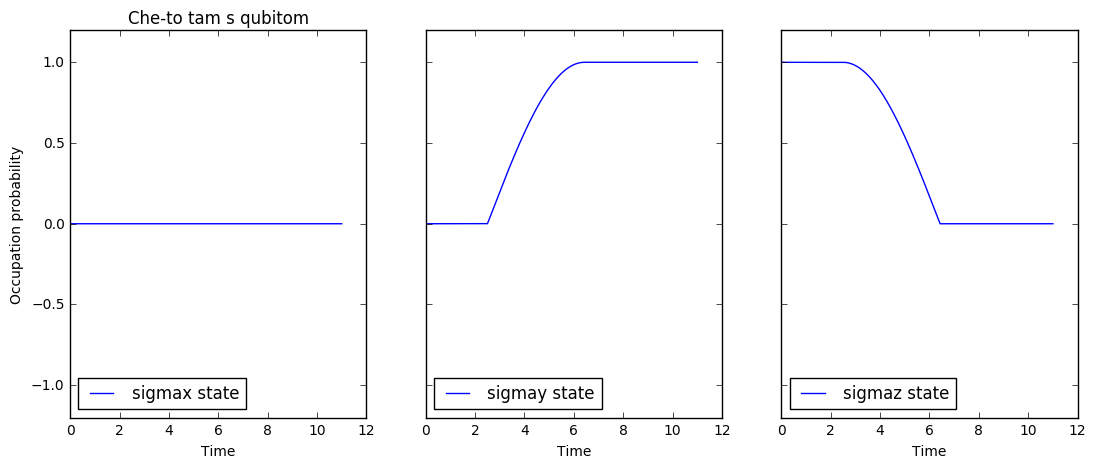

In [90]:
args['b'] = args['a'] + np.pi/f/2
output = solve(expected)
print(output.expect[2][-1])
visualize_output(output)

### $\pi$  pulse

10.0%. Run time:   0.15s. Est. time left: 00:00:00:01
20.0%. Run time:   0.29s. Est. time left: 00:00:00:01
30.0%. Run time:   0.45s. Est. time left: 00:00:00:01
40.0%. Run time:   0.60s. Est. time left: 00:00:00:00
50.0%. Run time:   0.76s. Est. time left: 00:00:00:00
60.0%. Run time:   0.91s. Est. time left: 00:00:00:00
70.0%. Run time:   1.07s. Est. time left: 00:00:00:00
80.0%. Run time:   1.22s. Est. time left: 00:00:00:00
90.0%. Run time:   1.37s. Est. time left: 00:00:00:00
Total run time:   1.52s
-1.0


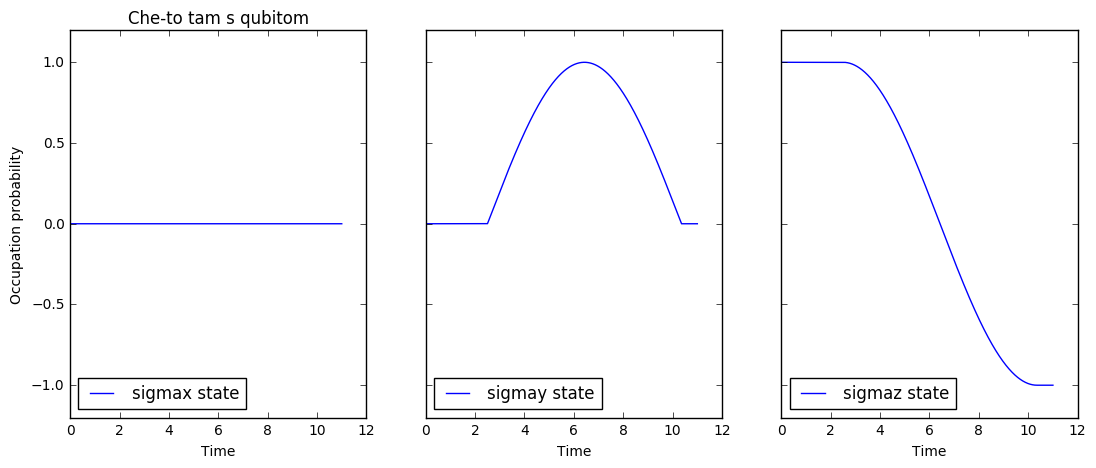

In [91]:
args['b'] = args['a'] + np.pi/f
output = solve(expected)
print(output.expect[2][-1])
visualize_output(output)